In [62]:
# Stop warnings
# -------------
import warnings
warnings.filterwarnings("ignore")

# General imports
# ---------------
import os
import sys
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import ipdb
import platform
import h5py
import time
import scipy.io
from sklearn import linear_model
from scipy.optimize import curve_fit
opj = os.path.join
deb = ipdb.set_trace
%matplotlib inline
regr = linear_model.LinearRegression()
import skimage.color as color

# MRI imports
# -----------
import nibabel as nb
import cortex

# Functions
# ---------
def m(x, w):
    return np.sum(x * w) / np.sum(w)

def cov(x, y, w):
    # see https://www2.microstrategy.com/producthelp/archive/10.8/FunctionsRef/Content/FuncRef/WeightedCov__weighted_covariance_.htm
    return np.sum(w * (x - m(x, w)) * (y - m(y, w))) / np.sum(w)

def weighted_corr(x, y, w):
    # see https://www2.microstrategy.com/producthelp/10.4/FunctionsRef/Content/FuncRef/WeightedCorr__weighted_correlation_.htm
    return cov(x, y, w) / np.sqrt(cov(x, x, w) * cov(y, y, w))

linear_function = lambda x, a, b: a * x + b


In [63]:
# Get data
# --------

# Define analysis parameters
# --------------------------
with open('/home/szinte/projects/retino_HCP/settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

# Define cluster/server specific parameters
# -----------------------------------------
base_dir = analysis_info["{}_base_folder".format(platform.uname()[1])] 
base_dir_indiv = analysis_info["{}_base_folder_indiv".format(platform.uname()[1])] 
fit_model = 'gauss'            

sign_idx, rsq_idx, ecc_idx, polar_real_idx, polar_imag_idx , size_idx, \
            non_lin_idx, amp_idx, baseline_idx, cov_idx, x_idx, y_idx, hemi_idx = 0,1,2,3,4,5,6,7,8,9,10,11,12

subjects =['999999','sub-01','sub-02']
for sub in analysis_info['subject_list']:subjects.append(sub)
subjects.append('sub-000')

pprf_ecc_size_r             = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_ecc_size_r_std         = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_ecc_size_slope         = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_ecc_size_slope_std     = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_ecc_size_intercept     = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_ecc_size_intercept_std = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_contra_lat_idx         = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_contra_lat_idx_std     = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_vertex                 = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
pprf_vertex_std             = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan

pprf_ecc_val                = np.zeros((len(subjects),len(analysis_info['rois']),10000))*np.nan
pprf_size_val               = np.zeros((len(subjects),len(analysis_info['rois']),10000))*np.nan

nprf_ecc_size_r             = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_ecc_size_r_std         = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_ecc_size_slope         = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_ecc_size_slope_std     = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_ecc_size_intercept     = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_ecc_size_intercept_std = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_contra_lat_idx         = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_contra_lat_idx_std     = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_vertex                 = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan
nprf_vertex_std             = np.zeros((len(subjects),len(analysis_info['rois'])))*np.nan

nprf_ecc_val                = np.zeros((len(subjects),len(analysis_info['rois']),10000))*np.nan
nprf_size_val               = np.zeros((len(subjects),len(analysis_info['rois']),10000))*np.nan

In [64]:
for mask_dir in ['pos','neg']:
    data_LR = []
    for roi_num, roi in enumerate(analysis_info['rois']):
        for subject_num, subject in enumerate(subjects[:-1]):

            if subject == 'sub-01':bs_dir = base_dir_indiv
            elif subject == 'sub-02':bs_dir = base_dir_indiv
            else:bs_dir = base_dir

            h5_dir = opj(bs_dir,'pp_data',subject,fit_model,'h5')

            data_hemi = []
            for hemi in ['L', 'R']:
                folder_alias = '{hemi}_{mask_dir}'.format(hemi = hemi,mask_dir = mask_dir)
                h5_file = h5py.File(opj(h5_dir,'{roi}.h5'.format(roi = roi)), "r")
                in_file = opj("prf_deriv_{hemi}_{mask_dir}".format(hemi = hemi, mask_dir = mask_dir))
                data = h5_file['{folder_alias}/{in_file}'.format(folder_alias=folder_alias,in_file=in_file)]

                if hemi == 'L': val_hemi = 1
                elif hemi == 'R': val_hemi = 2
                data = np.vstack((data,val_hemi*np.ones((1,data.shape[1]))))

                data = data[:,:].T
                data_hemi.append(data)

            data_LR = np.row_stack((data_hemi[0],data_hemi[1]))

            data4mask = data_LR
            
            # thresholds
            size_th             = data4mask[:,size_idx]>=analysis_info['r_size_threshold_down']
            size_th_up          = data4mask[:,size_idx]<=analysis_info['r_size_threshold_up']
            ecc_down_th         = data4mask[:,ecc_idx]>=analysis_info['r_ecc_threshold_down']
            ecc_up_th           = data4mask[:,ecc_idx]<=analysis_info['r_ecc_threshold_up']            
            
            all_th              = np.array((size_th,size_th_up,ecc_down_th,ecc_up_th)) 
            data_LR             = data_LR[np.logical_and.reduce(all_th)]
            data_LR = data_LR[~np.isnan(data_LR[:,rsq_idx])]
            vertex = data_LR.shape[0]
            
            if vertex >= 2:
                new_order = np.random.permutation(vertex)
                data_LR = data_LR[new_order,:]

                ecc_data = data_LR[:,ecc_idx]
                size_data = data_LR[:,size_idx]
                weight_data = data_LR[:,rsq_idx]
                
                regr.fit(ecc_data.reshape(-1, 1), size_data.reshape(-1, 1),weight_data)
                
                ecc_size_r = weighted_corr(ecc_data,size_data,weight_data)
                ecc_size_slope = regr.coef_
                ecc_size_intercept = regr.intercept_
            else:
                ecc_size_r = np.nan
                ecc_size_slope = np.nan
                ecc_size_intercept = np.nan
            
            
            # compute laterality index
            data_L = data_LR[data_LR[:,hemi_idx]==1,:]
            contra_lat_L = np.nansum(data_L[data_L[:,x_idx] < 0,rsq_idx])/np.nansum(data_L[:,rsq_idx])
            data_R = data_LR[data_LR[:,hemi_idx]==2,:]
            contra_lat_R = np.nansum(data_R[data_R[:,x_idx] > 0,rsq_idx])/np.nansum(data_R[:,rsq_idx])
            contra_lat_idx = np.nanmean([contra_lat_L,contra_lat_R]) * (vmax-vmin) + vmin

            # save data
            if mask_dir == 'pos':
                pprf_ecc_size_r[subject_num,roi_num] = ecc_size_r
                pprf_ecc_size_slope[subject_num,roi_num] = ecc_size_slope
                pprf_ecc_size_intercept[subject_num,roi_num] = ecc_size_intercept
                pprf_contra_lat_idx[subject_num,roi_num] = contra_lat_idx
                pprf_vertex[subject_num,roi_num] = vertex
                pprf_ecc_val[subject_num,roi_num,0:vertex] = ecc_data[0:vertex]
                pprf_size_val[subject_num,roi_num,0:vertex] = size_data[0:vertex]
            elif mask_dir == 'neg':
                nprf_ecc_size_r[subject_num,roi_num] = ecc_size_r
                nprf_ecc_size_slope[subject_num,roi_num] = ecc_size_slope
                nprf_ecc_size_intercept[subject_num,roi_num] = ecc_size_intercept
                nprf_contra_lat_idx[subject_num,roi_num] = contra_lat_idx
                nprf_vertex[subject_num,roi_num] = vertex
                nprf_ecc_val[subject_num,roi_num,0:vertex] = ecc_data[0:vertex]
                nprf_size_val[subject_num,roi_num,0:vertex] = size_data[0:vertex]

In [65]:
# compute average across HCP subjects
for roi_num, roi in enumerate(analysis_info['rois']):
    pprf_ecc_size_r[-1,roi_num]             = np.nanmean(pprf_ecc_size_r[3:-1,roi_num],axis = 0)
    pprf_ecc_size_r_std[-1,roi_num]         = np.nanstd(pprf_ecc_size_r[3:-1,roi_num],axis=0,ddof=1)
    pprf_ecc_size_slope[-1,roi_num]         = np.nanmean(pprf_ecc_size_slope[3:-1,roi_num],axis = 0)
    pprf_ecc_size_slope_std[-1,roi_num]     = np.nanstd(pprf_ecc_size_slope[3:-1,roi_num],axis=0,ddof=1)
    pprf_ecc_size_intercept[-1,roi_num]     = np.nanmean(pprf_ecc_size_intercept[3:-1,roi_num],axis = 0)
    pprf_ecc_size_intercept_std[-1,roi_num] = np.nanstd(pprf_ecc_size_intercept[3:-1,roi_num],axis=0,ddof=1)
    pprf_contra_lat_idx[-1,roi_num]         = np.nanmean(pprf_contra_lat_idx[3:-1,roi_num],axis = 0)
    pprf_contra_lat_idx_std[-1,roi_num]     = np.nanstd(pprf_contra_lat_idx[3:-1,roi_num],axis=0,ddof=1)
    pprf_vertex[-1,roi_num]                 = np.nanmean(pprf_vertex[3:-1,roi_num],axis = 0)
    pprf_vertex_std[-1,roi_num]             = np.nanstd(pprf_vertex[3:-1,roi_num],axis=0,ddof=1)
    
    nprf_ecc_size_r[-1,roi_num]             = np.nanmean(nprf_ecc_size_r[3:-1,roi_num],axis = 0)
    nprf_ecc_size_r_std[-1,roi_num]         = np.nanstd(nprf_ecc_size_r[3:-1,roi_num],axis=0,ddof=1)
    nprf_ecc_size_slope[-1,roi_num]         = np.nanmean(nprf_ecc_size_slope[3:-1,roi_num],axis = 0)
    nprf_ecc_size_slope_std[-1,roi_num]     = np.nanstd(nprf_ecc_size_slope[3:-1,roi_num],axis=0,ddof=1)
    nprf_ecc_size_intercept[-1,roi_num]     = np.nanmean(nprf_ecc_size_intercept[3:-1,roi_num],axis = 0)
    nprf_ecc_size_intercept_std[-1,roi_num] = np.nanstd(nprf_ecc_size_intercept[3:-1,roi_num],axis=0,ddof=1)
    nprf_contra_lat_idx[-1,roi_num]         = np.nanmean(nprf_contra_lat_idx[3:-1,roi_num],axis = 0)
    nprf_contra_lat_idx_std[-1,roi_num]     = np.nanstd(nprf_contra_lat_idx[3:-1,roi_num],axis=0,ddof=1)
    nprf_vertex[-1,roi_num]                 = np.nanmean(nprf_vertex[3:-1,roi_num],axis = 0)
    nprf_vertex_std[-1,roi_num]             = np.nanstd(nprf_vertex[3:-1,roi_num],axis=0,ddof=1)

In [66]:
def plot_fig3():
    
    all_sub2draw = [184,0,1,2]
    
    # Define colors
    # -------------
    transparency = 0.4

    # Low level vision
    V1_color            = (250/255.0, 190/255.0, 190/255.0,  1.0)
    V2_color            = (230/255.0,  25/255.0,  75/255.0,  1.0)
    V3_color            = (128/255.0,   0/255.0,   0/255.0,  1.0)
    VO_color            = (255/255.0, 215/255.0, 180/255.0,  1.0)
    DO_color            = (245/255.0, 130/255.0,  48/255.0,  1.0)
    LO_color            = (170/255.0, 110/255.0,  40/255.0,  1.0)
    low_colors = np.vstack((V1_color,V2_color,V3_color,VO_color,DO_color,LO_color))
    low_colors_alpha = np.vstack((V1_color,V2_color,V3_color,VO_color,DO_color,LO_color))
    low_colors_alpha[:,-1] = transparency

    # High level colors
    SUP_PAR_color       = ( 60/255.0, 180/255.0,  75/255.0,  1.0)
    TPJ_color           = ( 70/255.0, 240/255.0, 240/255.0,  1.0)
    sPCS_color          = (  0/255.0, 128/255.0, 128/255.0,  1.0)
    iPCS_color          = (170/255.0, 225/255.0, 195/255.0,  1.0)
    mPCS_color          = (255/255.0, 255/255.0, 200/255.0,  1.0)
    INS_color           = (255/255.0, 225/255.0,  25/255.0,  1.0)
    DLPFC_color         = (128/255.0, 128/255.0,   0/255.0,  1.0)

    high_colors = np.vstack((SUP_PAR_color,TPJ_color,sPCS_color,iPCS_color,mPCS_color,INS_color,DLPFC_color))
    high_colors_alpha = np.vstack((SUP_PAR_color,TPJ_color,sPCS_color,iPCS_color,mPCS_color,INS_color,DLPFC_color))
    high_colors_alpha[:,-1] = transparency

    # Default network colors
    ANG_color           = (  0/255.0, 130/255.0, 200/255.0,  1.0)
    MED_PAR_color       = (  0/255.0,   0/255.0, 128/255.0,  1.0)
    LAT_TEMP_color      = (230/255.0, 190/255.0, 255/255.0,  1.0)
    SUP_MED_FR_color    = (145/255.0,  30/255.0, 180/255.0,  1.0)
    dmn_colors = np.vstack((ANG_color,MED_PAR_color,LAT_TEMP_color,SUP_MED_FR_color))
    dmn_colors_alpha = np.vstack((ANG_color,MED_PAR_color,LAT_TEMP_color,SUP_MED_FR_color))
    dmn_colors_alpha[:,-1] = transparency

    all_colors = np.vstack((low_colors,high_colors,dmn_colors))
    all_colors_alpha = np.vstack((low_colors_alpha,high_colors_alpha,dmn_colors_alpha))
    all_colors_alpha = color.rgba2rgb(all_colors_alpha.reshape((17,1,4)))
    all_colors_alpha= all_colors_alpha.reshape(17,3)

    vmin,vmax = -1,1
    
    # Define figure
    fig = plt.figure(figsize=(7.09*2.54, 3.75*2.54))
    grid = plt.GridSpec(6,4,hspace = 3,wspace = 0.2)

    # Figure 3A
    # ---------
    bg_col = (0.9, 0.9, 0.9)
    axis_width = 0.75
    line_width_corr = 1.5

    ax1 = fig.add_subplot(grid[0:3, 0])
    ax2 = fig.add_subplot(grid[0:3, 1])
    ax3 = fig.add_subplot(grid[3:6, 0])
    ax4 = fig.add_subplot(grid[3:6, 1])

    title_font = {'loc':'left','fontname':'Helvetica', 'fontsize':7, 'fontweight':'bold'}
    axis_tick_font = {'fontname':'Helvetica', 'fontsize':6}
    axis_label_font = {'fontname':'Helvetica', 'fontsize':7}

    early_vis_rois_len = np.arange(len(analysis_info['early_vis_rois']))
    late_vis_rois_len = np.arange(len(analysis_info['late_vis_rois']))
    dmn_rois_len = np.arange(len(analysis_info['dmn_rois']))
    bg_col = (0.9, 0.9, 0.9)
    axis_width = 0.75

    axs = ['ax1','ax2','ax3','ax4']
    ax4.axis('off')

    # Titles
    ax1.set_title('Low level vision areas',**title_font)
    ax2.set_title('High level vision areas',**title_font)
    ax3.set_title('Default network areas',**title_font)

    # Remove left and top line and make axis right size
    for ax in axs:
        exec("{}.spines['top'].set_visible(False)".format(ax))
        exec("{}.spines['right'].set_visible(False)".format(ax))
        exec("{}.spines['left'].set_linewidth(axis_width)".format(ax))
        exec("{}.spines['bottom'].set_linewidth(axis_width)".format(ax))

    # Define background color
    for ax in axs:
        exec("{}.set_facecolor(bg_col)".format(ax))

    # X min and X ticknum
    xmin1,xmax1 = 0,10
    xmin2,xmax2 = 0,10
    xmin3,xmax3 = 0,10
    x_tick_num1 = 6
    x_tick_num2 = 6 
    x_tick_num3 = 6

    # Y min and  Y ticknum
    ymin1,ymax1 = 0,10
    ymin2,ymax2 = 0,10
    ymin3,ymax3 = 0,10
    y_tick_num1 = 6 
    y_tick_num2 = 6 
    y_tick_num3 = 6

    # Y lim
    ax1.set_ylim(bottom=ymin1, top=ymax1)
    ax2.set_ylim(bottom=ymin2, top=ymax2)
    ax3.set_ylim(bottom=ymin3, top=ymax3)

    # Y label
    ax1.set_ylabel('PPRF size (dva)',axis_label_font)
    ax2.set_ylabel('PPRF size (dva)',axis_label_font)
    ax3.set_ylabel('NPRF size (dva)',axis_label_font)

    # Y Ticks
    y_tick1 = np.linspace(ymin1,ymax1,y_tick_num1)
    y_tick2 = np.linspace(ymin2,ymax2,y_tick_num2)
    y_tick3 = np.linspace(ymin3,ymax3,y_tick_num3)
    ax1.set_yticks(y_tick1)
    ax2.set_yticks(y_tick2)
    ax3.set_yticks(y_tick3)

    # Y Tickslabel
    y_tick_label1 = []
    for t in zip(y_tick1):y_tick_label1.append('%2.0f'%t)
    ax1.set_yticklabels(y_tick_label1,**axis_tick_font)
    y_tick_label2 = []
    for t in zip(y_tick2):y_tick_label2.append('%2.0f'%t)
    ax2.set_yticklabels(y_tick_label2,**axis_tick_font)
    y_tick_label3 = []
    for t in zip(y_tick3):y_tick_label3.append('%2.0f'%t)
    ax3.set_yticklabels(y_tick_label3,**axis_tick_font)

    # X lim
    ax1.set_xlim(left=xmin1, right=xmax1)
    ax2.set_xlim(left=xmin2, right=xmax2)
    ax3.set_xlim(left=xmin3, right=xmax3)

    # X label
    ax1.set_xlabel('PPRF eccentricity (dva)',axis_label_font)
    ax2.set_xlabel('PPRF eccentricity (dva)',axis_label_font)
    ax3.set_xlabel('NPRF eccentricity (dva)',axis_label_font)

    # X Ticks
    x_tick1 = np.linspace(xmin1,xmax1,x_tick_num1)
    x_tick2 = np.linspace(xmin2,xmax2,x_tick_num2)
    x_tick3 = np.linspace(xmin3,xmax3,x_tick_num3)
    ax1.set_xticks(x_tick1)
    ax2.set_xticks(x_tick2)
    ax3.set_xticks(x_tick3)

    # X Tickslabel
    x_tick_label1 = []
    for t in zip(x_tick1):x_tick_label1.append('%2.0f'%t)
    ax1.set_xticklabels(x_tick_label1,**axis_tick_font)
    x_tick_label2 = []
    for t in zip(x_tick2):x_tick_label2.append('%2.0f'%t)
    ax2.set_xticklabels(x_tick_label2,**axis_tick_font)
    x_tick_label3 = []
    for t in zip(x_tick3):x_tick_label3.append('%2.0f'%t)
    ax3.set_xticklabels(x_tick_label3,**axis_tick_font)


    # plot eccentricity.size low level vision
    # ---------------------------------------
    subject_num = 0
    rois_selection = [0,1,2,3,4,5]
    for roi_num in rois_selection:
        all_ecc_val = pprf_ecc_val[subject_num,roi_num,:]
        all_size_val = pprf_size_val[subject_num,roi_num,:]
        ax1.plot(all_ecc_val,all_size_val,'o', markersize = 3, color= all_colors_alpha[roi_num], markeredgewidth=0)
    
    for roi_num in rois_selection:
        x_ecc_size = x_tick1
        slope_val = pprf_ecc_size_slope[subject_num,roi_num]
        intercept_val = pprf_ecc_size_intercept[subject_num,roi_num]
        y_ecc_size = linear_function(x_ecc_size,slope_val,intercept_val)
        ax1.plot(x_ecc_size,y_ecc_size,color= all_colors[roi_num] ,linewidth=line_width_corr)
        
    rois_selection = [6,7,8,9,10,11,12,13]
    for roi_num in rois_selection:
        all_ecc_val = pprf_ecc_val[subject_num,roi_num,:]
        all_size_val = pprf_size_val[subject_num,roi_num,:]
        ax2.plot(all_ecc_val,all_size_val,'o', markersize = 3, color= all_colors_alpha[roi_num], markeredgewidth=0)
        
    for roi_num in rois_selection:
        x_ecc_size = x_tick1
        slope_val = pprf_ecc_size_slope[subject_num,roi_num]
        intercept_val = pprf_ecc_size_intercept[subject_num,roi_num]
        y_ecc_size = linear_function(x_ecc_size,slope_val,intercept_val)
        ax2.plot(x_ecc_size,y_ecc_size,color = all_colors[roi_num],linewidth=line_width_corr)
        
    rois_selection = [13,14,15,16]
    for roi_num in rois_selection:
        all_ecc_val = nprf_ecc_val[subject_num,roi_num,:]
        all_size_val = nprf_size_val[subject_num,roi_num,:]
        ax3.plot(all_ecc_val,all_size_val,'o', markersize = 3, color= all_colors_alpha[roi_num], markeredgewidth=0)

    for roi_num in rois_selection:
        x_ecc_size = x_tick1
        slope_val = nprf_ecc_size_slope[subject_num,roi_num]
        intercept_val = nprf_ecc_size_intercept[subject_num,roi_num]
        y_ecc_size = linear_function(x_ecc_size,slope_val,intercept_val)
        ax3.plot(x_ecc_size,y_ecc_size,color = all_colors[roi_num],linewidth=line_width_corr)

    # Figure 3B
    # ---------
    ax5  = fig.add_subplot(grid[0:2, 2])
    ax6  = fig.add_subplot(grid[0:2, 3])
    ax7  = fig.add_subplot(grid[2:4, 2])
    ax8  = fig.add_subplot(grid[2:4, 3])
    ax9  = fig.add_subplot(grid[4:6, 2])
    ax10 = fig.add_subplot(grid[4:6, 3])

    # Settings

    axs = ['ax5','ax6','ax7','ax8','ax9','ax10']

    # Titles
    ax5.set_title('Low level vision areas',**title_font)
    ax7.set_title('High level vision areas',**title_font)
    ax9.set_title('Default network areas',**title_font)

    # Remove left and top line and make axis right size
    for ax in axs:
        exec("{}.spines['top'].set_visible(False)".format(ax))
        exec("{}.spines['right'].set_visible(False)".format(ax))
        exec("{}.spines['left'].set_linewidth(axis_width)".format(ax))
        exec("{}.spines['bottom'].set_linewidth(axis_width)".format(ax))

    # Define background color
    for ax in axs:
        exec("{}.set_facecolor(bg_col)".format(ax))

        
    # Y min and Y tick num
    ymin5,ymax5 = -1,1
    ymin6,ymax6 = -1,1
    ymin7,ymax7 = -1,1
    ymin8,ymax8 = -1,1
    ymin9,ymax9 = -1,1
    ymin10,ymax10 = -1,1
    y_tick_num5 = 5 
    y_tick_num6 = 5 
    y_tick_num7 = 5
    y_tick_num8 = 5
    y_tick_num9 = 5
    y_tick_num10 = 5
        
    # Y lim
    ax5.set_ylim(bottom=ymin5, top=ymax5)
    ax6.set_ylim(bottom=ymin6, top=ymax6)
    ax7.set_ylim(bottom=ymin7, top=ymax7)
    ax8.set_ylim(bottom=ymin8, top=ymax8)
    ax9.set_ylim(bottom=ymin9, top=ymax9)
    ax10.set_ylim(bottom=ymin10, top=ymax10)

    # Y label
    ax5.set_ylabel('PPRF\nr [ECCENTRICITY.SIZE]',axis_label_font)
    ax6.set_ylabel('PPRF\nlaterality index',axis_label_font)
    ax7.set_ylabel('PPRF\nr [ECCENTRICITY.SIZE]',axis_label_font)
    ax8.set_ylabel('PPRF\nlaterality index',axis_label_font)
    ax9.set_ylabel('NPRF\nr [ECCENTRICITY.SIZE]',axis_label_font)
    ax10.set_ylabel('NPRF\nlaterality index',axis_label_font)

    # Y Ticks
    y_tick5 = np.linspace(ymin5,ymax5,y_tick_num5)
    y_tick6 = np.linspace(ymin6,ymax6,y_tick_num6)
    y_tick7 = np.linspace(ymin7,ymax7,y_tick_num7)
    y_tick8 = np.linspace(ymin8,ymax8,y_tick_num8)
    y_tick9 = np.linspace(ymin9,ymax9,y_tick_num9)
    y_tick10 = np.linspace(ymin10,ymax10,y_tick_num10)
    ax5.set_yticks(y_tick5)
    ax6.set_yticks(y_tick6)
    ax7.set_yticks(y_tick7)
    ax8.set_yticks(y_tick8)
    ax9.set_yticks(y_tick9)
    ax10.set_yticks(y_tick10)

    # Y Tick label
    y_tick_label5 = []
    for t in zip(y_tick5):y_tick_label5.append('%1.2g'%t)
    y_tick_label6 = []
    for t in zip(y_tick6):y_tick_label6.append('%1.2g'%t)
    y_tick_label7 = []
    for t in zip(y_tick7):y_tick_label7.append('%1.2g'%t)
    y_tick_label8 = []
    for t in zip(y_tick8):y_tick_label8.append('%1.2g'%t)
    y_tick_label9 = []
    for t in zip(y_tick9):y_tick_label9.append('%1.2g'%t)
    y_tick_label10 = []
    for t in zip(y_tick10):y_tick_label10.append('%1.2g'%t)
    ax5.set_yticklabels(y_tick_label5,**axis_tick_font)
    ax6.set_yticklabels(y_tick_label6,**axis_tick_font)
    ax7.set_yticklabels(y_tick_label7,**axis_tick_font)
    ax8.set_yticklabels(y_tick_label8,**axis_tick_font)
    ax9.set_yticklabels(y_tick_label9,**axis_tick_font)
    ax10.set_yticklabels(y_tick_label10,**axis_tick_font)

    # X Ticks
    ax5.set_xticks(early_vis_rois_len)
    ax6.set_xticks(early_vis_rois_len)
    ax7.set_xticks(late_vis_rois_len)
    ax8.set_xticks(late_vis_rois_len)
    ax9.set_xticks(dmn_rois_len)
    ax10.set_xticks(dmn_rois_len)

    # X lim
    ax5.set_xlim(left=early_vis_rois_len[0]-1, right=early_vis_rois_len[-1]+1)
    ax6.set_xlim(left=early_vis_rois_len[0]-1, right=early_vis_rois_len[-1]+1)
    ax7.set_xlim(left=late_vis_rois_len[0]-1, right=late_vis_rois_len[-1]+1)
    ax8.set_xlim(left=late_vis_rois_len[0]-1, right=late_vis_rois_len[-1]+1)
    ax9.set_xlim(left=dmn_rois_len[0]-1, right=dmn_rois_len[-1]+1)
    ax10.set_xlim(left=dmn_rois_len[0]-1, right=dmn_rois_len[-1]+1)

    # X Ticks Label
    ax5.set_xticklabels(analysis_info['early_vis_rois'],**axis_tick_font,rotation = 45)
    ax6.set_xticklabels(analysis_info['early_vis_rois'],**axis_tick_font,rotation = 45)
    ax7.set_xticklabels(analysis_info['late_vis_rois'],**axis_tick_font,rotation = 45)
    ax8.set_xticklabels(analysis_info['late_vis_rois'],**axis_tick_font,rotation = 45)
    ax9.set_xticklabels(analysis_info['dmn_rois'],**axis_tick_font,rotation = 45)
    ax10.set_xticklabels(analysis_info['dmn_rois'],**axis_tick_font,rotation = 45)

    # zero lines
    line_x_early = np.arange(early_vis_rois_len[0]-1,early_vis_rois_len[-1]+2)
    line_x_late = np.arange(late_vis_rois_len[0]-1,late_vis_rois_len[-1]+2)
    line_x_dmn = np.arange(dmn_rois_len[0]-1,dmn_rois_len[-1]+2)
    ax5.plot(line_x_early,line_x_early*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax6.plot(line_x_early,line_x_early*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax7.plot(line_x_late,line_x_late*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax8.plot(line_x_late,line_x_late*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax9.plot(line_x_dmn,line_x_dmn*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    ax10.plot(line_x_dmn,line_x_dmn*0,color = [0.5,0.5,0.5],linewidth = axis_width)
    
    # text legend
    early_text_x = early_vis_rois_len[-1]+1 - (early_vis_rois_len[-1]+1)*0.05
    late_text_x = late_vis_rois_len[-1]+1 - (late_vis_rois_len[-1]+1)*0.05
    dmn_text_x = dmn_rois_len[-1]+1 - (dmn_rois_len[-1]+1)*0.05
    ax6.text(early_text_x, 0.5, 'ipsi.', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax6.text(early_text_x, -0.5, 'contra.', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax8.text(late_text_x, 0.5, 'ipsi.', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax8.text(late_text_x, -0.5, 'contra.', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax10.text(dmn_text_x, 0.5, 'ipsi.', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)
    ax10.text(dmn_text_x, -0.5, 'contra.', horizontalalignment='center', verticalalignment='center', rotation = 90, fontname = 'Helvetica', fontsize =6)

    # define colors
    ax5_col = low_colors
    ax6_col = low_colors
    ax7_col = high_colors
    ax8_col = high_colors
    ax9_col = dmn_colors
    ax10_col = dmn_colors
    
    # define bar distance and width
    dist_early = 0.15 * (3.0/len(all_sub2draw))
    dist_late = len(analysis_info['late_vis_rois'])*(dist_early/len(analysis_info['early_vis_rois']))
    dist_dmn = len(analysis_info['dmn_rois'])*(dist_early/len(analysis_info['early_vis_rois']))

    width_early = 0.15 *(3.0/len(all_sub2draw))
    width_late = len(analysis_info['late_vis_rois'])*(width_early/len(analysis_info['early_vis_rois']))
    width_dmn = len(analysis_info['dmn_rois'])*(width_early/len(analysis_info['early_vis_rois']))

    # Plot all data
    # -------------
    for sub2draw_num,sub2draw in enumerate(all_sub2draw):
        if sub2draw == 1:
            rois_low   = [0,1,2,3,4,5]
            rois_high  = [6,7,8,9]
            rois_dn    = [13,14,15]
        elif sub2draw == 2:
            rois_low   = [0,1,2,3,4,5]
            rois_high  = [6,7,8,9]
            rois_dn    = [13,14,15]
        else:
            rois_low   = [0,1,2,3,4,5]
            rois_high  = [6,7,8,9,10,11,12]
            rois_dn    = [13,14,15,16]

        # r[ECCENTRICITY.SIZE]
        # --------------------
        ax5_x = np.arange(len(rois_low))  + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_early*(len(all_sub2draw)/3.0))
        ax7_x = np.arange(len(rois_high)) + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_late*(len(all_sub2draw)/3.0))
        ax9_x = np.arange(len(rois_dn))   + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_dmn*(len(all_sub2draw)/3.0))
        ax5_y,ax7_y,ax9_y = pprf_ecc_size_r[sub2draw,rois_low],pprf_ecc_size_r[sub2draw,rois_high],nprf_ecc_size_r[sub2draw,rois_dn]
        ax5.bar(ax5_x,ax5_y,color = ax5_col, width = width_early)
        ax7.bar(ax7_x,ax7_y,color = ax7_col,width = width_late)
        ax9.bar(ax9_x,ax9_y,color = ax9_col,width = width_dmn)
        if sub2draw == 184:
            ax5_yerr = pprf_ecc_size_r_std[sub2draw,rois_low]
            ax7_yerr = pprf_ecc_size_r_std[sub2draw,rois_high]
            ax9_yerr = nprf_ecc_size_r_std[sub2draw,rois_dn]
            ax5.errorbar(ax5_x,ax5_y,[ax5_yerr*0,ax5_yerr], xerr = None, ecolor = ax5_col, elinewidth = 0.5, linestyle = 'none')
            ax5.errorbar(ax5_x,ax5_y,[ax5_yerr,ax5_yerr*0], xerr = None, ecolor = bg_col, elinewidth = 0.5, linestyle = 'none')
            ax7.errorbar(ax7_x,ax7_y,[ax7_yerr*0,ax7_yerr], xerr = None, ecolor = ax7_col, elinewidth = 0.5, linestyle = 'none')
            ax7.errorbar(ax7_x,ax7_y,[ax7_yerr,ax7_yerr*0], xerr = None, ecolor = bg_col, elinewidth = 0.5, linestyle = 'none')
            ax9.errorbar(ax9_x,ax9_y,[ax9_yerr*0,ax9_yerr], xerr = None, ecolor = ax9_col, elinewidth = 0.5, linestyle = 'none')
            ax9.errorbar(ax9_x,ax9_y,[ax9_yerr,ax9_yerr*0], xerr = None, ecolor = bg_col, elinewidth = 0.5, linestyle = 'none')

        # Laterality index
        # ----------------
        ax6_x = np.arange(len(rois_low))  + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_early*(len(all_sub2draw)/3.0))
        ax8_x = np.arange(len(rois_high)) + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_late*(len(all_sub2draw)/3.0))
        ax10_x = np.arange(len(rois_dn))  + ((sub2draw_num+1)-(len(all_sub2draw)/2.0+0.5))*(dist_dmn*(len(all_sub2draw)/3.0))
        ax6_y,ax8_y,ax10_y = pprf_contra_lat_idx[sub2draw,rois_low],pprf_contra_lat_idx[sub2draw,rois_high],nprf_contra_lat_idx[sub2draw,rois_dn]
        ax6.bar(ax6_x,ax6_y,color = ax6_col, width = width_early)
        ax8.bar(ax8_x,ax8_y,color = ax8_col,width = width_late)
        ax10.bar(ax10_x,ax10_y,color = ax10_col,width = width_dmn)
        
        if sub2draw == 184:
            ax6_yerr = pprf_contra_lat_idx_std[sub2draw,rois_low]
            ax8_yerr = pprf_contra_lat_idx_std[sub2draw,rois_high]
            ax10_yerr = nprf_contra_lat_idx_std[sub2draw,rois_dn]
            ax6.errorbar(ax6_x,ax6_y,[ax6_yerr,ax6_yerr*0], xerr = None, ecolor = ax6_col, elinewidth = 0.5, linestyle = 'none')
            ax6.errorbar(ax6_x,ax6_y,[ax6_yerr*0,ax6_yerr], xerr = None, ecolor = bg_col, elinewidth = 0.5, linestyle = 'none')
            ax8.errorbar(ax8_x,ax8_y,[ax8_yerr,ax8_yerr*0], xerr = None, ecolor = ax8_col, elinewidth = 0.5, linestyle = 'none')
            ax8.errorbar(ax8_x,ax8_y,[ax8_yerr*0,ax8_yerr], xerr = None, ecolor = bg_col, elinewidth = 0.5, linestyle = 'none')
            ax10.errorbar(ax10_x,ax10_y,[ax10_yerr,ax10_yerr*0], xerr = None, ecolor = ax10_col, elinewidth = 0.5, linestyle = 'none')
            ax10.errorbar(ax10_x,ax10_y,[ax10_yerr*0,ax10_yerr], xerr = None, ecolor = bg_col, elinewidth = 0.5, linestyle = 'none')
        

In [67]:
img_dir1 = '/home/szinte/projects/retino_HCP/post_fit/notebooks/figs/Figure3/'
img_dir2 = '/home/szinte/projects/retino_HCP/post_fit/notebooks/figs/FigureS3/'
try: os.makedirs(img_dir1)
except: pass
try: os.makedirs(img_dir2)
except: pass

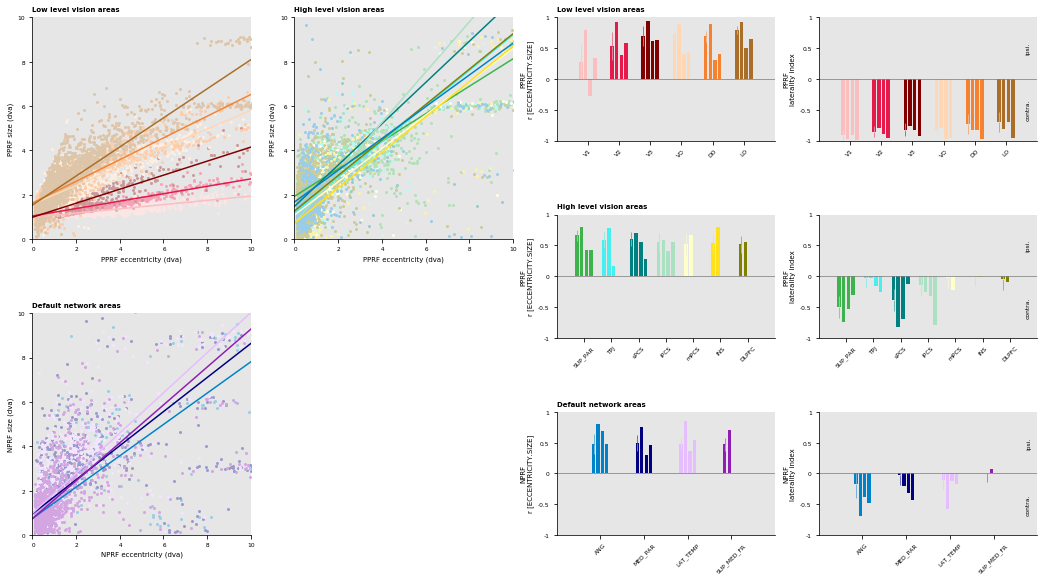

In [68]:
plot_fig3()
plt.savefig("{imdir}figure3.pdf".format(imdir = img_dir1),facecolor='w')

In [60]:
def plot_figS3():
    # Figure S3
    # ---------
    fig_x_size = 4
    fig = plt.figure(figsize=(7.09*2.54, 3.75*2.54))
    grid = plt.GridSpec(6,4,hspace = 3,wspace = 0.2)

    # Settings
    bg_col = (0.9, 0.9, 0.9)
    axis_width = 0.75
    line_width_corr = 1.5

    title_font = {'loc':'left','fontname':'Helvetica', 'fontsize':7, 'fontweight':'bold'}
    axis_tick_font = {'fontname':'Helvetica', 'fontsize':6}
    axis_label_font = {'fontname':'Helvetica', 'fontsize':7}

    early_vis_rois_len = np.arange(len(analysis_info['early_vis_rois']))
    late_vis_rois_len = np.arange(len(analysis_info['late_vis_rois']))
    dmn_rois_len = np.arange(len(analysis_info['dmn_rois']))
    bg_col = (0.9, 0.9, 0.9)
    axis_width = 0.75

    # Figure S3A
    # -----------
    ax1 = fig.add_subplot(grid[0:3, 0])
    ax2 = fig.add_subplot(grid[0:3, 1])
    ax3 = fig.add_subplot(grid[3:6, 0])
    ax4 = fig.add_subplot(grid[3:6, 1])

    xmin1,xmax1 = 0,10
    xmin2,xmax2 = 0,10
    xmin3,xmax3 = 0,10
    x_tick_num1 = 6
    x_tick_num2 = 6 
    x_tick_num3 = 6

    ymin1,ymax1 = 0,8
    ymin2,ymax2 = 0,8
    ymin3,ymax3 = 0,8
    y_tick_num1 = 5 
    y_tick_num2 = 5 
    y_tick_num3 = 5

    axs = ['ax1','ax2','ax3','ax4']
    ax4.axis('off')

    # Titles
    ax1.set_title('Low level vision areas',**title_font)
    ax2.set_title('High level vision areas',**title_font)
    ax3.set_title('Default network areas',**title_font)

    # Remove left and top line and make axis right size
    for ax in axs:
        exec("{}.spines['top'].set_visible(False)".format(ax))
        exec("{}.spines['right'].set_visible(False)".format(ax))
        exec("{}.spines['left'].set_linewidth(axis_width)".format(ax))
        exec("{}.spines['bottom'].set_linewidth(axis_width)".format(ax))

    # Define background color
    for ax in axs:
        exec("{}.set_facecolor(bg_col)".format(ax))

    # Y lim
    ax1.set_ylim(bottom=ymin1, top=ymax1)
    ax2.set_ylim(bottom=ymin2, top=ymax2)
    ax3.set_ylim(bottom=ymin3, top=ymax3)

    # Y label
    ax1.set_ylabel('PPRF size (dva)',axis_label_font)
    ax2.set_ylabel('PPRF size (dva)',axis_label_font)
    ax3.set_ylabel('NPRF size (dva)',axis_label_font)

    # Y Ticks
    y_tick1 = np.linspace(ymin1,ymax1,y_tick_num1)
    y_tick2 = np.linspace(ymin2,ymax2,y_tick_num2)
    y_tick3 = np.linspace(ymin3,ymax3,y_tick_num3)
    ax1.set_yticks(y_tick1)
    ax2.set_yticks(y_tick2)
    ax3.set_yticks(y_tick3)

    # Y Tickslabel
    y_tick_label1 = []
    for t in zip(y_tick1):y_tick_label1.append('%2.0f'%t)
    ax1.set_yticklabels(y_tick_label1,**axis_tick_font)
    y_tick_label2 = []
    for t in zip(y_tick2):y_tick_label2.append('%2.0f'%t)
    ax2.set_yticklabels(y_tick_label2,**axis_tick_font)
    y_tick_label3 = []
    for t in zip(y_tick3):y_tick_label3.append('%2.0f'%t)
    ax3.set_yticklabels(y_tick_label3,**axis_tick_font)


    # X lim
    ax1.set_xlim(left=xmin1, right=xmax1)
    ax2.set_xlim(left=xmin2, right=xmax2)
    ax3.set_xlim(left=xmin3, right=xmax3)

    # X label
    ax1.set_xlabel('PPRF eccentricity (dva)',axis_label_font)
    ax2.set_xlabel('PPRF eccentricity (dva)',axis_label_font)
    ax3.set_xlabel('NPRF eccentricity (dva)',axis_label_font)

    # X Ticks
    x_tick1 = np.linspace(xmin1,xmax1,x_tick_num1)
    x_tick2 = np.linspace(xmin2,xmax2,x_tick_num2)
    x_tick3 = np.linspace(xmin3,xmax3,x_tick_num3)
    ax1.set_xticks(x_tick1)
    ax2.set_xticks(x_tick2)
    ax3.set_xticks(x_tick3)

    # X Tickslabel
    x_tick_label1 = []
    for t in zip(x_tick1):x_tick_label1.append('%2.0f'%t)
    ax1.set_xticklabels(x_tick_label1,**axis_tick_font)
    x_tick_label2 = []
    for t in zip(x_tick2):x_tick_label2.append('%2.0f'%t)
    ax2.set_xticklabels(x_tick_label2,**axis_tick_font)
    x_tick_label3 = []
    for t in zip(x_tick3):x_tick_label3.append('%2.0f'%t)
    ax3.set_xticklabels(x_tick_label3,**axis_tick_font)


    # plot eccentricity.size low level vision
    # ---------------------------------------
    subject_num = 1
    rois_selection = [0,1,2,3,4,5]
    for roi_num in rois_selection:
        all_ecc_val = pprf_ecc_val[subject_num,roi_num,:]
        all_size_val = pprf_size_val[subject_num,roi_num,:]
        ax1.plot(all_ecc_val,all_size_val,'o', markersize = 3, color= all_colors_alpha[roi_num], markeredgewidth=0)
    
    for roi_num in rois_selection:
        x_ecc_size = x_tick1
        slope_val = pprf_ecc_size_slope[subject_num,roi_num]
        intercept_val = pprf_ecc_size_intercept[subject_num,roi_num]
        y_ecc_size = linear_function(x_ecc_size,slope_val,intercept_val)
        ax1.plot(x_ecc_size,y_ecc_size,color= all_colors[roi_num] ,linewidth=line_width_corr)
        
    rois_selection = [6,7,8,9]
    for roi_num in rois_selection:
        all_ecc_val = pprf_ecc_val[subject_num,roi_num,:]
        all_size_val = pprf_size_val[subject_num,roi_num,:]
        ax2.plot(all_ecc_val,all_size_val,'o', markersize = 3, color= all_colors_alpha[roi_num], markeredgewidth=0)
        
    for roi_num in rois_selection:
        x_ecc_size = x_tick1
        slope_val = pprf_ecc_size_slope[subject_num,roi_num]
        intercept_val = pprf_ecc_size_intercept[subject_num,roi_num]
        y_ecc_size = linear_function(x_ecc_size,slope_val,intercept_val)
        ax2.plot(x_ecc_size,y_ecc_size,color = all_colors[roi_num],linewidth=line_width_corr)
        
    rois_selection = [13,14,15]
    for roi_num in rois_selection:
        all_ecc_val = nprf_ecc_val[subject_num,roi_num,:]
        all_size_val = nprf_size_val[subject_num,roi_num,:]
        ax3.plot(all_ecc_val,all_size_val,'o', markersize = 3, color= all_colors_alpha[roi_num], markeredgewidth=0)

    for roi_num in rois_selection:
        x_ecc_size = x_tick1
        slope_val = nprf_ecc_size_slope[subject_num,roi_num]
        intercept_val = nprf_ecc_size_intercept[subject_num,roi_num]
        y_ecc_size = linear_function(x_ecc_size,slope_val,intercept_val)
        ax3.plot(x_ecc_size,y_ecc_size,color = all_colors[roi_num],linewidth=line_width_corr)

    # Figure S3B
    # ----------
    ax5 = fig.add_subplot(grid[0:3, 2])
    ax6 = fig.add_subplot(grid[0:3, 3])
    ax7 = fig.add_subplot(grid[3:6, 2])
    ax8 = fig.add_subplot(grid[3:6, 3])

    xmin5,xmax5 = 0,10
    xmin6,xmax6 = 0,10
    xmin7,xmax7 = 0,10
    x_tick_num5 = 6 
    x_tick_num6 = 6 
    x_tick_num7 = 6
    
    ymin5,ymax5 = 0,10
    ymin6,ymax6 = 0,10
    ymin7,ymax7 = 0,10
    y_tick_num5 = 6 
    y_tick_num6 = 6 
    y_tick_num7 = 6
    

    axs = ['ax5','ax6','ax7','ax8']
    ax8.axis('off')

    # Titles
    ax5.set_title('Low level vision areas',**title_font)
    ax6.set_title('High level vision areas',**title_font)
    ax7.set_title('Default network areas',**title_font)

    # Remove left and top line and make axis right size
    for ax in axs:
        exec("{}.spines['top'].set_visible(False)".format(ax))
        exec("{}.spines['right'].set_visible(False)".format(ax))
        exec("{}.spines['left'].set_linewidth(axis_width)".format(ax))
        exec("{}.spines['bottom'].set_linewidth(axis_width)".format(ax))

    # Define background color
    for ax in axs:
        exec("{}.set_facecolor(bg_col)".format(ax))

    # Y lim
    ax5.set_ylim(bottom=ymin5, top=ymax5)
    ax6.set_ylim(bottom=ymin6, top=ymax6)
    ax7.set_ylim(bottom=ymin7, top=ymax7)

    # Y label
    ax5.set_ylabel('PPRF size (dva)',axis_label_font)
    ax6.set_ylabel('PPRF size (dva)',axis_label_font)
    ax7.set_ylabel('NPRF size (dva)',axis_label_font)

    # Y Ticks
    y_tick5 = np.linspace(ymin5,ymax5,y_tick_num5)
    y_tick6 = np.linspace(ymin6,ymax6,y_tick_num6)
    y_tick7 = np.linspace(ymin7,ymax7,y_tick_num7)
    ax5.set_yticks(y_tick5)
    ax6.set_yticks(y_tick6)
    ax7.set_yticks(y_tick7)

    # Y Tickslabel
    y_tick_label5 = []
    for t in zip(y_tick5):y_tick_label5.append('%2.0f'%t)
    ax5.set_yticklabels(y_tick_label5,**axis_tick_font)
    y_tick_label6 = []
    for t in zip(y_tick6):y_tick_label6.append('%2.0f'%t)
    ax6.set_yticklabels(y_tick_label6,**axis_tick_font)
    y_tick_label7 = []
    for t in zip(y_tick7):y_tick_label7.append('%2.0f'%t)
    ax7.set_yticklabels(y_tick_label7,**axis_tick_font)

    # X lim
    ax5.set_xlim(left=xmin5, right=xmax5)
    ax6.set_xlim(left=xmin6, right=xmax6)
    ax7.set_xlim(left=xmin7, right=xmax7)

    # X label
    ax5.set_xlabel('PPRF eccentricity (dva)',axis_label_font)
    ax6.set_xlabel('PPRF eccentricity (dva)',axis_label_font)
    ax7.set_xlabel('NPRF eccentricity (dva)',axis_label_font)

    # X Ticks
    x_tick5 = np.linspace(xmin5,xmax6,x_tick_num5)
    x_tick6 = np.linspace(xmin5,xmax6,x_tick_num6)
    x_tick7 = np.linspace(xmin5,xmax6,x_tick_num7)
    ax5.set_xticks(x_tick5)
    ax6.set_xticks(x_tick6)
    ax7.set_xticks(x_tick7)

    # X Tickslabel
    x_tick_label5 = []
    for t in zip(x_tick5):x_tick_label5.append('%2.0f'%t)
    ax5.set_xticklabels(x_tick_label5,**axis_tick_font)
    x_tick_label6 = []
    for t in zip(x_tick6):x_tick_label6.append('%2.0f'%t)
    ax6.set_xticklabels(x_tick_label6,**axis_tick_font)
    x_tick_label7 = []
    for t in zip(x_tick7):x_tick_label7.append('%2.0f'%t)
    ax7.set_xticklabels(x_tick_label7,**axis_tick_font)

    # plot eccentricity.size low level vision
    # ---------------------------------------
    subject_num = 2
    rois_selection = [0,1,2,3,4,5]
    for roi_num in rois_selection:
        all_ecc_val = pprf_ecc_val[subject_num,roi_num,:]
        all_size_val = pprf_size_val[subject_num,roi_num,:]
        ax5.plot(all_ecc_val,all_size_val,'o', markersize = 3, color= all_colors_alpha[roi_num], markeredgewidth=0)
        
    for roi_num in rois_selection:
        x_ecc_size = x_tick5
        slope_val = pprf_ecc_size_slope[subject_num,roi_num]
        intercept_val = pprf_ecc_size_intercept[subject_num,roi_num]
        y_ecc_size = linear_function(x_ecc_size,slope_val,intercept_val)
        ax5.plot(x_ecc_size,y_ecc_size,color= all_colors[roi_num] ,linewidth=line_width_corr)

    rois_selection = [6,7,8,9]
    for roi_num in rois_selection:
        all_ecc_val = pprf_ecc_val[subject_num,roi_num,:]
        all_size_val = pprf_size_val[subject_num,roi_num,:]
        ax6.plot(all_ecc_val,all_size_val,'o', markersize = 3, color= all_colors_alpha[roi_num], markeredgewidth=0)
            
    for roi_num in rois_selection:
        x_ecc_size = x_tick6
        slope_val = pprf_ecc_size_slope[subject_num,roi_num]
        intercept_val = pprf_ecc_size_intercept[subject_num,roi_num]
        y_ecc_size = linear_function(x_ecc_size,slope_val,intercept_val)
        ax6.plot(x_ecc_size,y_ecc_size,color = all_colors[roi_num],linewidth=line_width_corr)

    rois_selection = [13,14,15]
    for roi_num in rois_selection:
        all_ecc_val = nprf_ecc_val[subject_num,roi_num,:]
        all_size_val = nprf_size_val[subject_num,roi_num,:]
        ax7.plot(all_ecc_val,all_size_val,'o', markersize = 3, color= all_colors_alpha[roi_num], markeredgewidth=0)
        
    for roi_num in rois_selection:
        x_ecc_size = x_tick7
        slope_val = nprf_ecc_size_slope[subject_num,roi_num]
        intercept_val = nprf_ecc_size_intercept[subject_num,roi_num]
        y_ecc_size = linear_function(x_ecc_size,slope_val,intercept_val)
        ax7.plot(x_ecc_size,y_ecc_size,color = all_colors[roi_num],linewidth=line_width_corr)

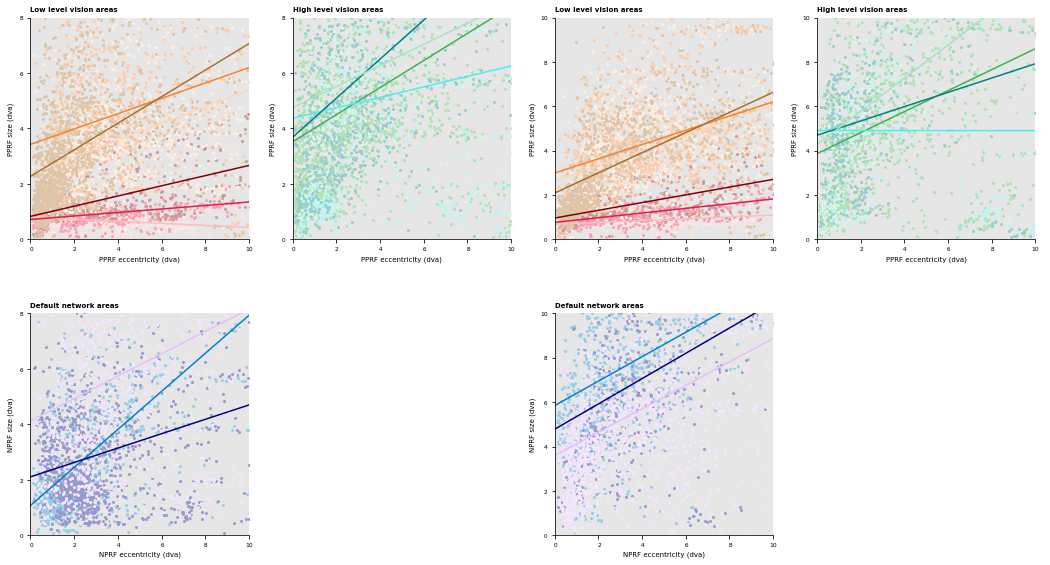

In [61]:
plot_figS3()
plt.savefig("{imdir}figureS3.pdf".format(imdir = img_dir2),facecolor='w')